In [1]:
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import lognorm
import math
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import panel as pn
import hvplot.pandas
import panel as pn
import hvplot.pandas
import numpy as np
import holoviews as hv


In [2]:
df = pd.read_csv('/Users/cemkoymen/Desktop/financial_reporting/credit_risk_dataset.csv')

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
mean_person_income = df.apply(lambda x: x['person_income'] if x['loan_status'] == 1 else None, axis=1).mean()
std_person_income = df.apply(lambda x: x['person_income'] if x['loan_status'] == 1 else None, axis=1).std()
mean_loan_percent_income = df.apply(lambda x: x['loan_percent_income'] if x['loan_status'] == 1 else None, axis=1).mean()
std_loan_percent_income = df.apply(lambda x: x['loan_percent_income'] if x['loan_status'] == 1 else None, axis=1).std()

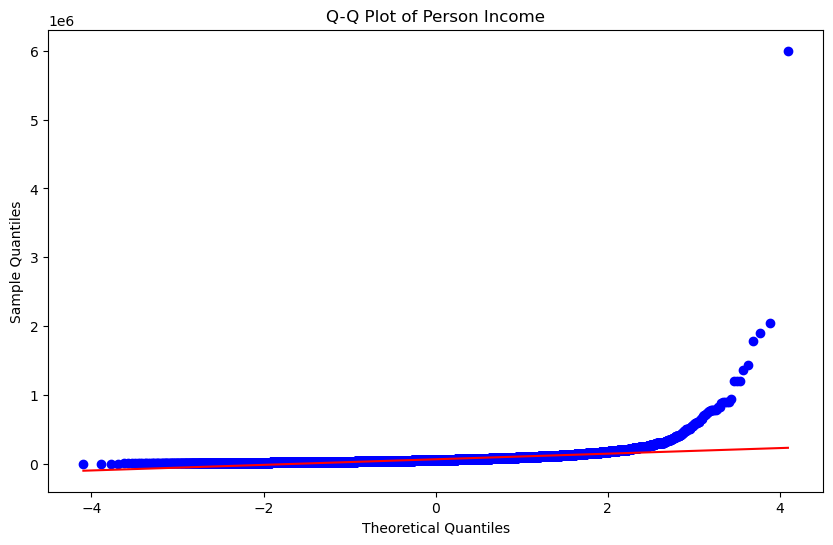

In [5]:
plt.figure(figsize=(10, 6))
stats.probplot(df['person_income'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Person Income')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [6]:
def detect_outliers(data):
    outliers = []
    threshold = 3
    for i in data['person_income']:
        z_score = (i - mean_person_income) / std_person_income
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers


Transformed DataFrame head:
   person_income  log_person_income
0          59000          10.985293
1           9600           9.169518
2           9600           9.169518
3          65500          11.089805
4          54400          10.904119


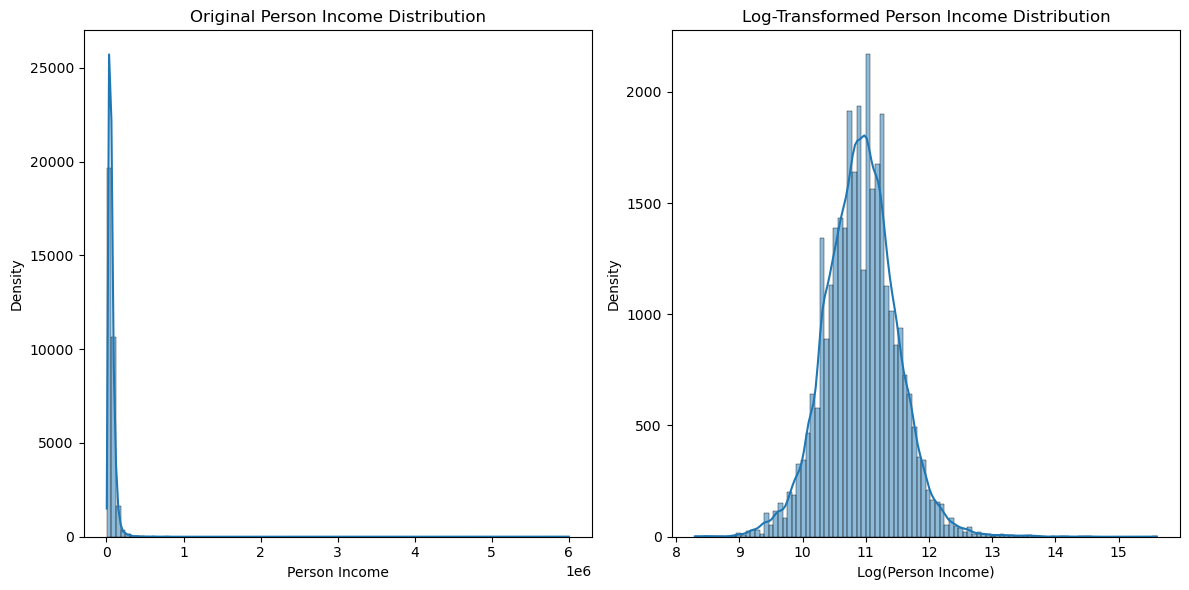

In [7]:
df['log_person_income'] = np.log(df['person_income'])
# Check for any issues in the transformed data
print("Transformed DataFrame head:")
print(df[['person_income', 'log_person_income']].head())

# Plot the original and log-transformed data
plt.figure(figsize=(12, 6))

# Original data distribution
plt.subplot(1, 2, 1)
sns.histplot(df['person_income'], bins=100, kde=True)
plt.title('Original Person Income Distribution')
plt.xlabel('Person Income')
plt.ylabel('Density')

# Log-transformed data distribution
plt.subplot(1, 2, 2)
sns.histplot(df['log_person_income'], bins=100, kde=True)
plt.title('Log-Transformed Person Income Distribution')
plt.xlabel('Log(Person Income)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [8]:
def compute_ecdf(group, column):
    ecdf = ECDF(group[column])
    return ecdf

# Compute ECDF for log_person_income
ecdf_log_person_income = compute_ecdf(df, 'log_person_income')

# Extract quantiles for log-transformed data
quantiles = [0.25, 0.5, 0.75]
log_person_income_quantiles = [ecdf_log_person_income.x[np.searchsorted(ecdf_log_person_income.y, q)] for q in quantiles]

print("Log-Transformed Person Income Quantiles:", log_person_income_quantiles)

# Optionally, convert the quantiles back to the original scale
original_scale_quantiles = np.exp(log_person_income_quantiles)
print("Original Scale Quantiles:", original_scale_quantiles)

Log-Transformed Person Income Quantiles: [10.558413520275876, 10.915088464214607, 11.279731577802517]
Original Scale Quantiles: [38500. 55000. 79200.]


In [9]:
threshold = 0.50

# Compute the covariance matrix for the filtered data directly
covariance_matrix = df[df['loan_percent_income'] > threshold][['log_person_income', 'loan_percent_income']].cov()

# Extract the covariance between person_income and loan_percent_income
covariance = covariance_matrix.loc['log_person_income', 'loan_percent_income']

print(f"Covariance between person_income and loan_percent_income (when loan_percent_income > {threshold}): {covariance:.4f}")

Covariance between person_income and loan_percent_income (when loan_percent_income > 0.5): -0.0084


In [10]:
pn.extension('plotly','tabulator')

In [11]:
# Enable Panel extension at the start
pn.extension('plotly', 'tabulator')

def create_credit_risk_dashboard(df):
    # Fill NaN values with 0
    df = df.fillna(0)
    
    # Create histogram of log income distribution with income threshold slider
    income_hist = pn.bind(
        lambda threshold: df.hvplot.hist(
            'log_person_income',
            bins=50,
            height=300,
            title='Distribution of Log Income',
            hover=True
        ).opts(xlabel='Log Income', ylabel='Count'),
        threshold=pn.widgets.FloatSlider(
            name='Income Threshold',
            start=df['log_person_income'].min(),
            end=df['log_person_income'].max(),
            value=df['log_person_income'].median()
        )
    )

    # Create scatter plot of income vs loan percent with default highlighting
    scatter = df.hvplot.scatter(
        'log_person_income',
        'loan_percent_income',
        by='loan_status',
        height=400,
        width=600,
        title='Income vs Loan Percent by Default Status',
        hover=True,
        cmap=['#1f77b4', '#ff7f0e']
    ).opts(
        xlabel='Log Income',
        ylabel='Loan Percent of Income'
    )

    # Create violin plot showing income distribution by default status
    violin = df.hvplot.violin(
        y='log_person_income',
        by='loan_status',
        height=300,
        title='Income Distribution by Default Status',
        hover=True
    ).opts(
        xlabel='Default Status',
        ylabel='Log Income'
    )

    # Calculate and display key metrics
    def calculate_metrics(df):
        metrics = {
            'Default Rate': f"{(df['loan_status'] == 1).mean():.2%}",
            'Median Income': f"${np.exp(df['log_person_income'].median()):,.2f}",
            'Median Loan %': f"{df['loan_percent_income'].median():.2%}",
            'High Risk Loans (>50% Income)': f"{(df['loan_percent_income'] > 0.5).mean():.2%}"
        }
        return pn.pane.Markdown('\n'.join([f"**{k}:** {v}" for k, v in metrics.items()]))

    metrics_pane = calculate_metrics(df)

    # Create threshold analysis with reactive updates
    threshold_widget = pn.widgets.FloatSlider(
        name='Loan/Income Threshold',
        start=0.1,
        end=1.0,
        value=0.5,
        step=0.05
    )

    @pn.depends(threshold_widget.param.value)
    def threshold_analysis(threshold):
        high_risk = df[df['loan_percent_income'] > threshold].fillna(0)
        if len(high_risk) == 0:
            return "No loans above this threshold"
        
        return f"""
        **Loan/Income Threshold Analysis (>{threshold:.0%})**
        - Number of loans: {len(high_risk):,}
        - Default rate: {(high_risk['loan_status'] == 1).mean():.2%}
        - Median income: ${np.exp(high_risk['log_person_income'].median()):,.2f}
        """

    threshold_pane = pn.pane.Markdown(threshold_analysis)

    # Arrange the dashboard
    dashboard = pn.Column(
        pn.Row(
            pn.Column(
                "# Credit Risk Analysis Dashboard",
                metrics_pane,
                threshold_widget,
                threshold_pane,
                width=400
            ),
            pn.Column(scatter)
        ),
        pn.Row(
            pn.Column(income_hist),
            pn.Column(violin)
        )
    )
    
    return dashboard

# Create the dashboard
dashboard = create_credit_risk_dashboard(df)
dashboard.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'e15a979f-eec1-41c5-805d-739f536c402d': {'version…